In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
#Data Manipulation

from scipy.sparse import csr_matrix
from collections import Counter

from sklearn.model_selection import train_test_split


import string

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet
from nltk.corpus import stopwords

nltk.download('punkt')

import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpor

In [2]:
dir = '../input/spam-dataset/'

df = pd.read_csv(dir+'spam.csv', encoding="ISO-8859-1")

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [6]:
df['Unnamed: 4'].value_counts()

Unnamed: 4
GNT:-)"                                                     2
 just Keep-in-touch\" gdeve.."                              1
 Never comfort me with a lie\" gud ni8 and sweet dreams"    1
 CALL 2MWEN IM BK FRMCLOUD 9! J X\""                        1
 one day these two will become FREINDS FOREVER!"            1
Name: count, dtype: int64

In [7]:
print(df['v1'].value_counts(normalize = True))

v1
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64


The dataset is unballanced with 87% of the data labelled as "ham" and 17% as "spam".

## Split the data

In [8]:
X = df['v2']
y = df['v1'].map({'ham':0,'spam':1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## Data Cleaning

We need to tokenize our data. To achieve this, we will do the following steps:

1. Transform each word to its lowercase.
2. Remove stop-words.
3. Lemmatize the document.
4. TF - IDF.


In [10]:
print(X_train.shape,y_train.shape, X_test.shape,y_test.shape)

(3733,) (3733,) (1839,) (1839,)


In [11]:
# Lemmatize the corpus
def get_wordnet_pos(treebank_tag):
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN

In [12]:
def Tokenizer(doc):
    wnl = WordNetLemmatizer()
    tokens = word_tokenize(doc) #List of strings in doc
        
    filtered_words = [token.lower() for token in tokens]
#    filtered_words = [token.lower() for token in tokens if (token.lower() not in stop_words) and (token.lower() not in string.punctuation)]
        
    words_and_tags = nltk.pos_tag(filtered_words)
    return " ".join([wnl.lemmatize(word, pos=get_wordnet_pos(tag)) \
            for word, tag in words_and_tags])

stop_words = stopwords.words('english')
X_clean = X_train.apply(Tokenizer)

In [13]:
X_clean[:5]

0    aight text me when you 're back at mu and i 'l...
1    i cant wait to see you ! how be the photo be u...
2                        kothi print out marandratha .
3    it just the effect of irritation . just ignore it
4                      kallis wont bat in 2nd inning .
Name: v2, dtype: object

In [14]:
def word2idx(documents):
    '''
        documents: Series object containing all the documents of the dataset
        word2idx: dictionary mapping word to index
    '''
    
    word2idx = {}
    idx2word = []  #We don't need to store the idx value if we create it as a list
    countidx = 0
    for doc in documents:
        tokens = word_tokenize(doc.lower())
        doc_as_int = []
        for token in tokens:
            if token not in word2idx:
                word2idx[token] = countidx
                idx2word.append(token)
                countidx+=1
            doc_as_int.append(word2idx[token])
    word2idx['<unknow>'] = len(idx2word)
    idx2word.append('<unknow>')
    return word2idx, idx2word

In [15]:
encoder, decoder = word2idx(X_clean)
decoder[-1]

'<unknow>'

In [16]:
vocab_size = len(decoder)
print(vocab_size)

7142


In [17]:
def tokenizer_doc(documents, encoder):
    tokenized_docs = []
    for doc in documents:
        tokens = word_tokenize(doc.lower())
        #print(tokens)
        doc_as_int = []
        for token in tokens:
            if token not in encoder:
                token = '<unknow>'    
            doc_as_int.append(encoder[token])
        tokenized_docs.append(doc_as_int)
    return tokenized_docs

In [18]:
tokenized_doc = tokenizer_doc(X_clean, encoder)

In [19]:
tokenized_doc[120]

[685,
 25,
 56,
 57,
 65,
 835,
 836,
 138,
 837,
 838,
 303,
 304,
 74,
 839,
 25,
 85,
 27,
 19,
 48,
 306,
 17,
 840,
 4,
 25,
 92,
 841,
 842,
 25,
 843,
 14,
 701]

In [20]:
X_clean[120]

'urgent ! your mobile no *********** win a å£2,000 bonus caller prize on 02/06/03 ! this be the 2nd attempt to reach you ! call 09066362220 asap ! box97n7qp , 150ppm'

In [21]:
#TF-IDF

#term-frequency



row = []
col = []
data = []
for i, doc_as_int in enumerate(tokenized_doc):
    
    count_tokens = Counter(doc_as_int)
    for token in count_tokens:
        data.append(count_tokens[token])
        row.append(i)
        col.append(token)
        

#row, col = zip(*position)

tf_cs = csr_matrix((data, (row, col)), shape=(len(tokenized_doc), vocab_size))

In [22]:
tf_cs.shape

(3733, 7142)

In [23]:
#Document frequency
df_cs = (tf_cs>=1)
df_sum = (df_cs.sum(axis = 0)+1)/tf_cs.shape[0]
df_sum.shape

(1, 7142)

In [24]:
#df_sum[0,-1] = 1 #Add one to <unknow> token 

In [25]:
#TF-IDF

tf_idf = (tf_cs/df_sum).tocsr()

In [26]:
row_num = 3150
row = tf_idf[row_num,:].toarray().flatten()
top_5_idx = np.argsort(-row)[:5]
top_5_values = row[top_5_idx]
print(f"Row text: {X_train[row_num]}")
print(f"Top 5 words: \n{[decoder[idx] for idx in top_5_idx]}")
print(f"Top 5 tf-idf:\n{top_5_values}")

Row text: ARE YOU IN TOWN? THIS IS V. IMPORTANT
Top 5 words: 
['v.', 'important', 'town', 'this', 'in']
Top 5 tf-idf:
[933.25       219.58823529 196.47368421  18.38916256   6.84954128]


In [27]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(tf_idf, y_train)

y_predict = (clf.predict(tf_idf))

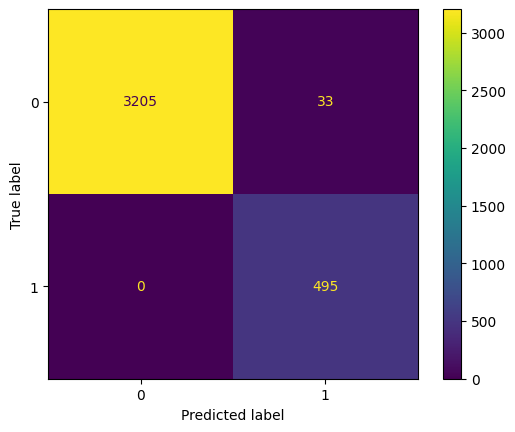

In [28]:
# Import the metrics module from scikit-learn
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# Calculate the values for each quadrant in the confusion matrix
cm = metrics.confusion_matrix(y_train, y_predict)

# Create the confusion matrix as a visualization
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

# Display the confusion matrix
disp.plot()

In [29]:
print('Accuracy:', '%.3f' % accuracy_score(y_train, y_predict))
print('Precision:', '%.3f' % precision_score(y_train, y_predict))
print('Recall:', '%.3f' % recall_score(y_train, y_predict))
print('F1 Score:', '%.3f' % f1_score(y_train, y_predict))
print('AUC:', '%.3f' % roc_auc_score(y_train, y_predict))

Accuracy: 0.991
Precision: 0.938
Recall: 1.000
F1 Score: 0.968
AUC: 0.995


## Evaluate model on test sample

In [30]:
X_clean_test = X_test.apply(Tokenizer)
tokenized_doc_test = tokenizer_doc(X_clean_test, encoder)

In [31]:
row = []
col = []
data = []
for i, doc_as_int in enumerate(tokenized_doc_test):
    
    count_tokens = Counter(doc_as_int)
    for token in count_tokens:
        data.append(count_tokens[token])
        row.append(i)
        col.append(token)
        

#row, col = zip(*position)

tf_cs = csr_matrix((data, (row, col)), shape=(len(tokenized_doc_test), vocab_size))

df_cs = (tf_cs>=1)
df_sum = (df_cs.sum(axis = 0)+1)/tf_cs.shape[0]
df_sum.shape

tf_idf_test = (tf_cs/df_sum).tocsr()

In [32]:
y_predict = (clf.predict(tf_idf_test))

In [33]:
print('Accuracy:', '%.3f' % accuracy_score(y_test, y_predict))
print('Precision:', '%.3f' % precision_score(y_test, y_predict))
print('Recall:', '%.3f' % recall_score(y_test, y_predict))
print('F1 Score:', '%.3f' % f1_score(y_test, y_predict))
print('AUC:', '%.3f' % roc_auc_score(y_test, y_predict))

Accuracy: 0.956
Precision: 0.819
Recall: 0.877
F1 Score: 0.847
AUC: 0.923


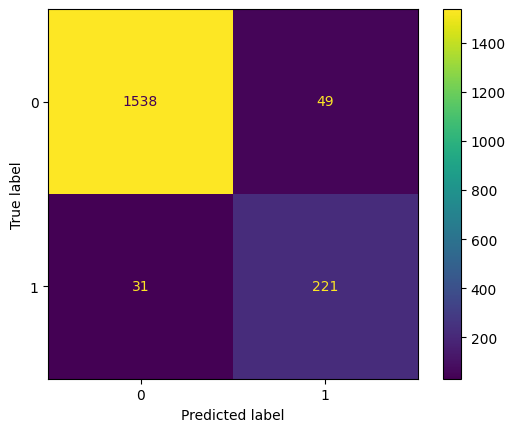

In [34]:
# Calculate the values for each quadrant in the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predict)

# Create the confusion matrix as a visualization
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

# Display the confusion matrix
disp.plot()

We did a very good job predicting which email was a spam. We achieve a recall score on the test sample of 0.907 and a F1 score of 0.866. Our worst score was the precision (0.83). Looking at the confusion matrix, we can see that we had more False Positive than False Negatives.

Now, all we need to do, is create a model that can be used to receive an email and label it

## Lets try to do better

1. Test using a library for tf-idf
2. Try to use CountWords

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

featurizer = TfidfVectorizer(decode_error='ignore')
Xtrain = featurizer.fit_transform(X_train)
Xtest = featurizer.transform(X_test)

clf = MultinomialNB()
clf.fit(Xtrain, y_train)

y_predict = clf.predict(Xtest)

In [36]:
# Metrics using TfidfVectorizer
print('Accuracy:', '%.3f' % accuracy_score(y_test, y_predict))
print('Precision:', '%.3f' % precision_score(y_test, y_predict))
print('Recall:', '%.3f' % recall_score(y_test, y_predict))
print('F1 Score:', '%.3f' % f1_score(y_test, y_predict))
print('AUC:', '%.3f' % roc_auc_score(y_test, y_predict))

Accuracy: 0.959
Precision: 1.000
Recall: 0.702
F1 Score: 0.825
AUC: 0.851


In [37]:
# try multiple ways of calculating features

featurizer = CountVectorizer(decode_error='ignore')
Xtrain = featurizer.fit_transform(X_train)
Xtest = featurizer.transform(X_test)

clf = MultinomialNB()
clf.fit(Xtrain, y_train)

y_predict = clf.predict(Xtest)

In [38]:
# Metrics using CountVectorizer
print('Accuracy:', '%.3f' % accuracy_score(y_test, y_predict))
print('Precision:', '%.3f' % precision_score(y_test, y_predict))
print('Recall:', '%.3f' % recall_score(y_test, y_predict))
print('F1 Score:', '%.3f' % f1_score(y_test, y_predict))
print('AUC:', '%.3f' % roc_auc_score(y_test, y_predict))

Accuracy: 0.983
Precision: 0.974
Recall: 0.897
F1 Score: 0.934
AUC: 0.947


# Creating the Model

In [39]:
class SpamDetector():
    def __init__(self):
        
        self.model = MultinomialNB()
        
        return
    
    def train_model(self, X_train, y_train):
        '''
            X_train: training input -> Series of strings
            y_train: training output -> 0 = not spam, 1 = spam
        '''
        
        X_clean = X_train.apply(self._Tokenizer)
        self._word2idx(X_clean)     
        tokenized_X = self._tokenizer_doc(X_clean)
        tf_idf = self._tf_idf(tokenized_X)
        
        self.model.fit(tf_idf, y_train)
    
    
    def __call__(self,email):
        #email = a single string containint the text of the email
        X_clean = self._Tokenizer(email)
        
        tokenized_X = self._tokenizer_doc([X_clean])
        tf_idf = self._tf_idf(tokenized_X)
        
        label = self.model.predict(tf_idf)[0]
        probs = self.model.predict_proba(tf_idf)[0]
        
        return label, probs
    
    
    
    def _tf_idf(self,tokenized_X):
        #Term Frequency
        row = []
        col = []
        data = []
        for i, doc_as_int in enumerate(tokenized_X):
            count_tokens = Counter(doc_as_int)
            for token in count_tokens:
                data.append(count_tokens[token])
                row.append(i)
                col.append(token)
        tf_cs = csr_matrix((data, (row, col)), shape=(len(tokenized_X), len(self.decoder)))
        
        #Document Frequency
        df_cs = (tf_cs>=1)
        df_sum = (df_cs.sum(axis = 0)+1)/tf_cs.shape[0]
        df_sum.shape
        tf_idf = (tf_cs/df_sum).tocsr()
        
        return tf_idf
        
        
    def _get_wordnet_pos(self, treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
        
        
    
    def _Tokenizer(self,x):
        wnl = WordNetLemmatizer()
        tokens = word_tokenize(x) #List of strings in doc

        filtered_words = [token.lower() for token in tokens]

        words_and_tags = nltk.pos_tag(filtered_words)
        return " ".join([wnl.lemmatize(word, pos=self._get_wordnet_pos(tag)) \
                for word, tag in words_and_tags])
    
    
    
    
    def _word2idx(self, X_clean):
        '''
            documents: Series object containing all the documents of the dataset
            word2idx: dictionary mapping word to index
        '''

        self.encoder = {}
        self.decoder = []  #We don't need to store the idx value if we create it as a list
        countidx = 0
        for doc in X_clean:
            tokens = word_tokenize(doc.lower())
            doc_as_int = []
            for token in tokens:
                if token not in self.encoder:
                    self.encoder[token] = countidx
                    self.decoder.append(token)
                    countidx+=1
                doc_as_int.append(self.encoder[token])
        self.encoder['<unknow>'] = len(self.decoder)
        self.decoder.append('<unknow>')
        return
    
    
    
    def _tokenizer_doc(self, X_clean):
        tokenized_docs = []
        for doc in X_clean:
            tokens = word_tokenize(doc.lower())
            doc_as_int = []
            for token in tokens:
                if token not in self.encoder:
                    token = '<unknow>'    
                doc_as_int.append(self.encoder[token])
            tokenized_docs.append(doc_as_int)
        return tokenized_docs

In [40]:
#object(email) -> Label/ Probabilities

spam_detector = SpamDetector()

In [41]:
spam_detector.train_model(X_train, y_train)

In [42]:
X_train[0]

"Aight text me when you're back at mu and I'll swing by, need somebody to get the door for me"

In [43]:
spam_detector(X_train[0])

(0, array([1.00000000e+00, 5.78497014e-11]))

In [44]:
y_preds = []
for x in X_test:
    label, probs = spam_detector(x)
    y_preds.append(label)

In [45]:
print('Accuracy:', '%.3f' % accuracy_score(y_test, y_preds))
print('Precision:', '%.3f' % precision_score(y_test, y_preds))
print('Recall:', '%.3f' % recall_score(y_test, y_preds))
print('F1 Score:', '%.3f' % f1_score(y_test, y_preds))
print('AUC:', '%.3f' % roc_auc_score(y_test, y_preds))

Accuracy: 0.981
Precision: 0.987
Recall: 0.873
F1 Score: 0.926
AUC: 0.936


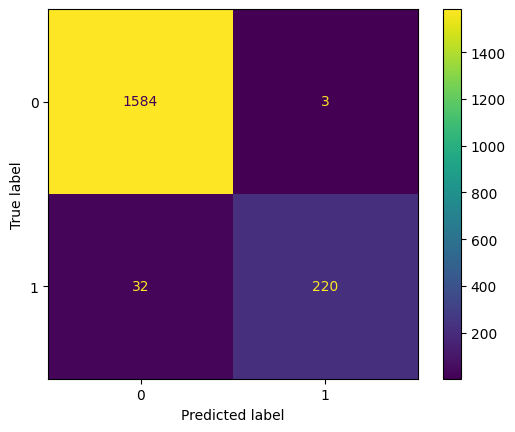

In [46]:
# Calculate the values for each quadrant in the confusion matrix
cm = metrics.confusion_matrix(y_test, y_preds)

# Create the confusion matrix as a visualization
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

# Display the confusion matrix
disp.plot()

## Applying Latent Semantic Analysis to Spam detection

In [47]:
# Lets apply the SVD to the training data and fit the test sample.
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

In [48]:
X_lsa_tr = X_train.apply(Tokenizer)
X_lsa_test = X_test.apply(Tokenizer)

In [49]:
featurizer = CountVectorizer(decode_error='ignore', stop_words='english')
Xtrain_lsa = featurizer.fit_transform(X_lsa_tr)
Xtest_lsa = featurizer.transform(X_lsa_test)

In [50]:
lsa = TruncatedSVD(n_components=25)
Z_tr = lsa.fit_transform(Xtrain_lsa)
Z_test = lsa.transform(Xtest_lsa)

In [51]:
rfc = RandomForestClassifier()
rfc.fit(Z_tr, y_train)

y_predict = rfc.predict(Z_test)

In [52]:
y_predict.sum()

207

In [53]:
print('Precision:', '%.3f' % precision_score(y_test, y_predict))
print('Recall:', '%.3f' % recall_score(y_test, y_predict))
print('F1 Score:', '%.3f' % f1_score(y_test, y_predict))
print('AUC:', '%.3f' % roc_auc_score(y_test, y_predict))

Precision: 0.981
Recall: 0.806
F1 Score: 0.885
AUC: 0.902


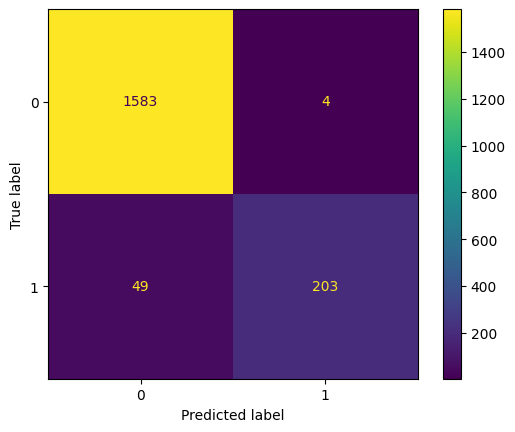

In [54]:
# Calculate the values for each quadrant in the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predict)

# Create the confusion matrix as a visualization
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

# Display the confusion matrix
disp.plot()

In [55]:
#Lets compare countvectorize with LSA:

features = np.array([2,4,6,8,10,50])

X_lsa_tr = X_train.apply(Tokenizer)
X_lsa_test = X_test.apply(Tokenizer)



acc_cv = []
rcll_cv = []
acc_lsa = []
rcll_lsa = []

for feats in features:
    feat_CV = CountVectorizer(decode_error='ignore', stop_words='english', max_features = feats)
    Xtrain_CV = feat_CV.fit_transform(X_lsa_tr)
    Xtest_CV = feat_CV.transform(X_lsa_test)
    
    feat_lsa = CountVectorizer(decode_error='ignore', stop_words='english')
    Xtrain_lsa = feat_lsa.fit_transform(X_lsa_tr)
    Xtest_lsa = feat_lsa.transform(X_lsa_test)
    lsa = TruncatedSVD(n_components=feats)
    Z_tr = lsa.fit_transform(Xtrain_lsa)
    Z_test = lsa.transform(Xtest_lsa)
    
    
    #Create model and fit
    rfc_CV = RandomForestClassifier()
    rfc_CV.fit(Xtrain_CV, y_train)
    y_predict_CV = rfc_CV.predict(Xtest_CV)
    
    rfc_lsa = RandomForestClassifier()
    rfc_lsa.fit(Z_tr, y_train)
    y_predict_lsa = rfc_lsa.predict(Z_test)
    
    rcll_cv.append(recall_score(y_test, y_predict_CV))
    rcll_lsa.append(recall_score(y_test, y_predict_lsa))
    
    acc_cv.append(accuracy_score(y_test, y_predict_CV))
    acc_lsa.append(accuracy_score(y_test, y_predict_lsa))

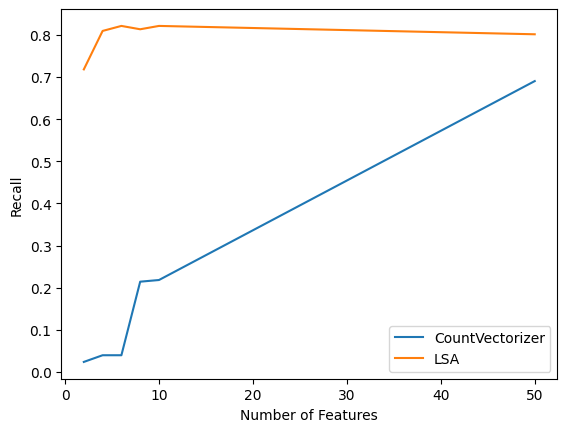

In [56]:
plt.plot(features, rcll_cv)
plt.plot(features, rcll_lsa)
plt.legend(["CountVectorizer","LSA"])
plt.ylabel("Recall")
plt.xlabel("Number of Features")
plt.show()